# EDA

### 학습 데이터 개요  
마스크를 착용하는 건 COIVD-19의 확산을 방지하는데 중요한 역할을 합니다. 제공되는 이 데이터셋은 사람이 마스크를 착용하였는지 판별하는 모델을 학습할 수 있게 해줍니다. 모든 데이터셋은 **아시아인 남녀**로 구성되어 있고 나이는 **20대부터 70대**까지 다양하게 분포하고 있습니다. 간략한 통계는 다음과 같습니다.

- 전체 사람 명 수 : **4,500**

- 한 사람당 사진의 개수: **7** 
    - 마스크 착용 **5**장, 
    - 이상하게 착용(코스크, 턱스크) **1**장, 
    - 미착용 **1**장

- 이미지 크기: **(384, 512)**

- 전체 데이터셋 중에서 **60%** 는 학습 데이터셋으로 활용됩니다.

- 입력값의 형태: 
    - 마스크 착용 사진, 미착용 사진, 혹은 이상하게 착용한 사진(코스크, 턱스크)
- 결과값의 형태:
    - 총 18개의 Label  

### 평가 데이터 개요
학습 데이터셋이 아닌 나머지 40%의 데이터셋 중에서 **20%는 public 테스트셋, 그리고 20%는 private 테스트셋**으로 사용됩니다.
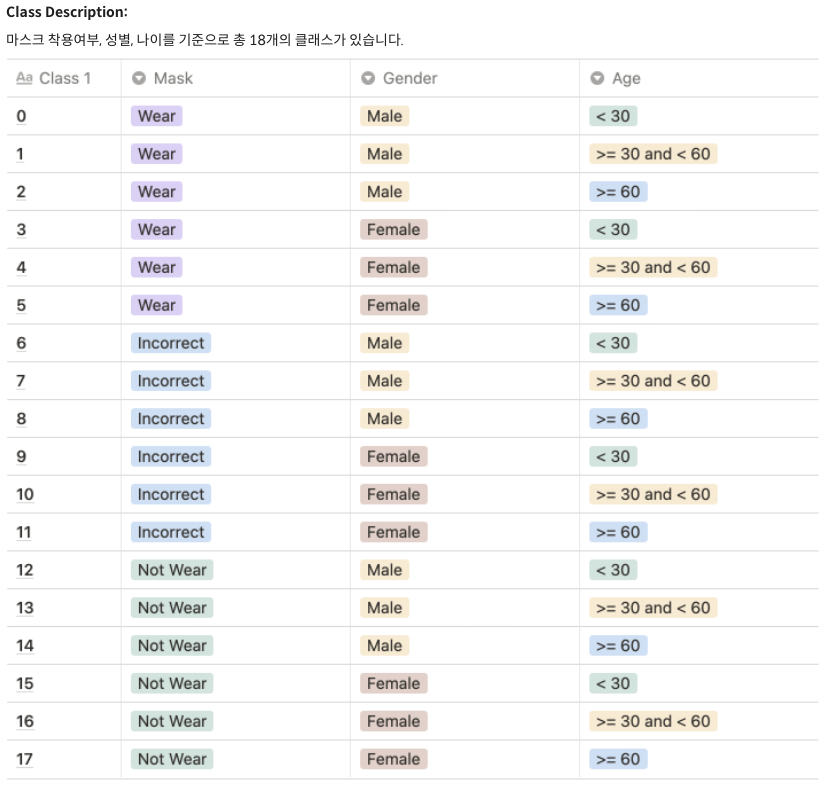

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# train data 경로
train_dir = '/opt/ml/input/data/train'

In [3]:
train_info = pd.read_csv(os.path.join(train_dir, 'train.csv'))
image_dir = os.path.join(train_dir, 'images')

In [4]:
# train.info : label을 생성할 수 있다. 
train_info.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

In [5]:
print('# of id : ', len(train_info))

# of id :  2700


In [6]:
# label 형태 ~ gender ~ age 조건문으로 만든다. 

In [7]:
image_paths = [os.path.join(image_dir, img_id) for img_id in train_info.path]
image_paths[:4]

['/opt/ml/input/data/train/images/000001_female_Asian_45',
 '/opt/ml/input/data/train/images/000002_female_Asian_52',
 '/opt/ml/input/data/train/images/000004_male_Asian_54',
 '/opt/ml/input/data/train/images/000005_female_Asian_58']

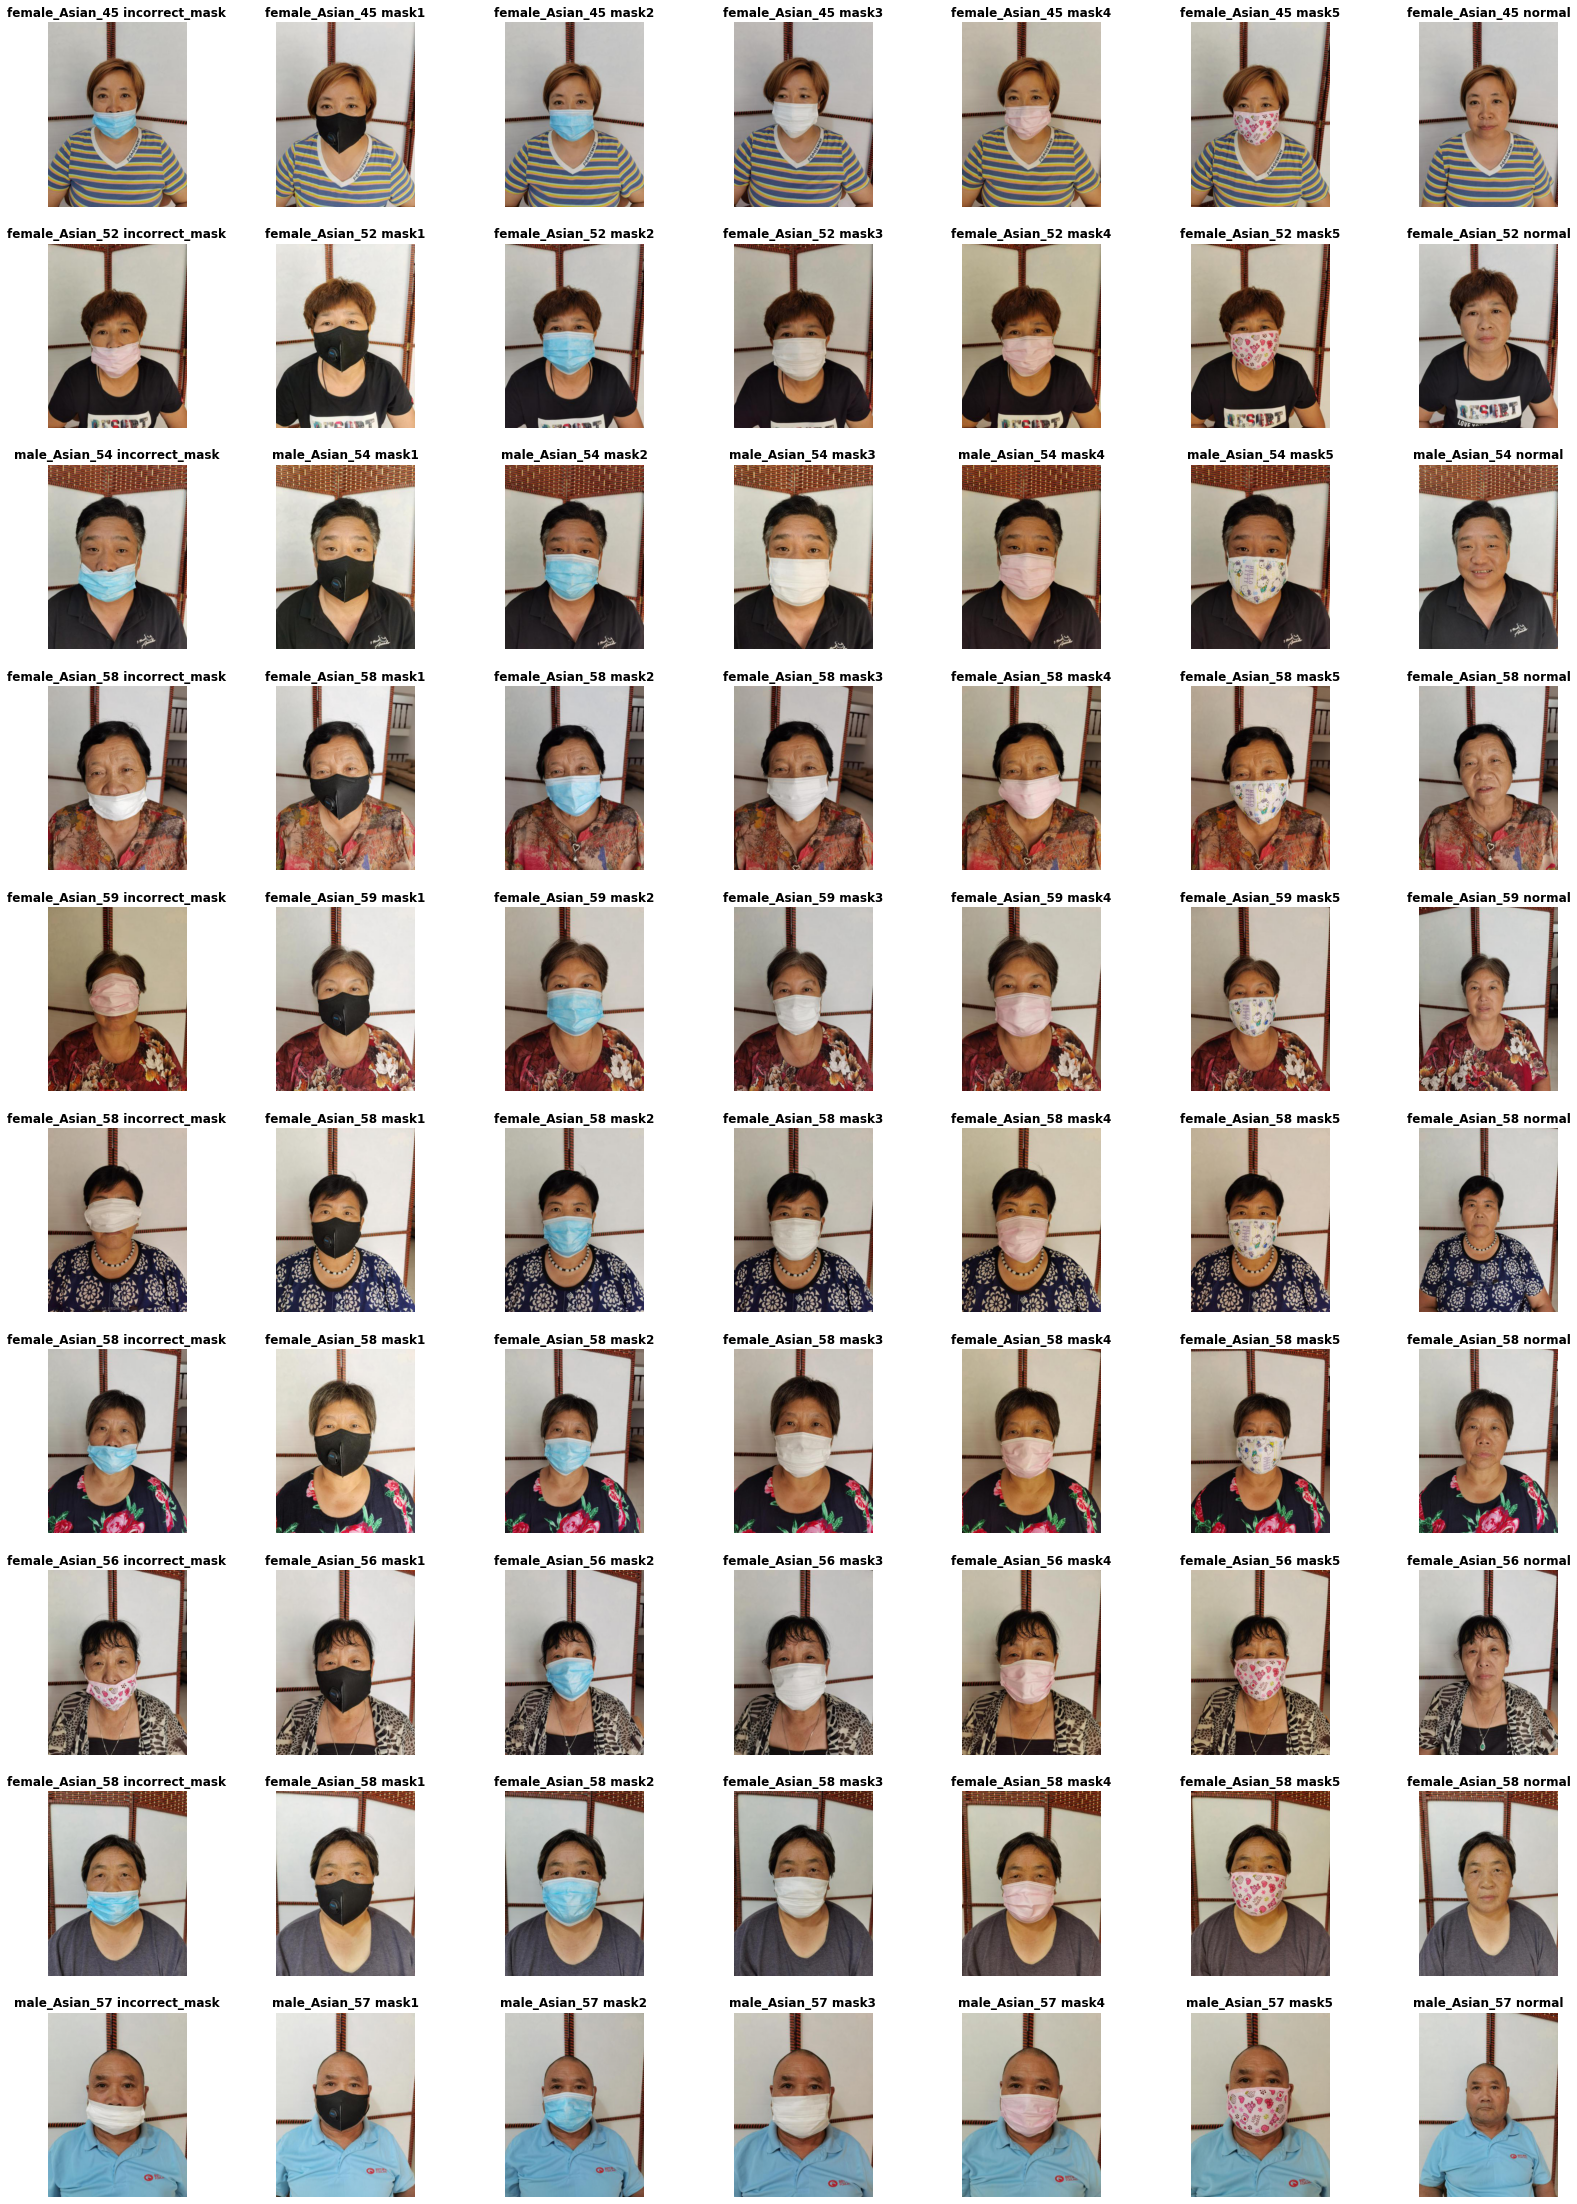

In [8]:
# 10명 X 7type

fig, axes = plt.subplots(10, 7, figsize=(28, 40))

for i, who in enumerate(image_paths[:10]):
    images = [image for image in os.listdir(who) if image[0] != '.']
    for j, types in enumerate(sorted(images)) : 
        axes[i][j].imshow(Image.open(os.path.join(who, types)))
        axes[i][j].set_title( who[39:] + ' ' + types[:-4]  , fontweight='bold')
        axes[i][j].axis('off')    

- **incorrect_mask** : 턱스크, 코스크
    - 마스크의 색상, 종류는 **무작위** 
- **mask1 ~ mask5** : 마스크 올바르게 착용 (마스크의 종류와 색상별로 구분되어있다.)
    - mask1 : 검은색, 특수 마스크
    - mask2 : 파란색,
    - mask3 : 흰 색,
    - mask4 : 분홍색,
    - mask5 : 무늬가 있거나, 특수한 모양의 마스크
    
- **normal** : 마스크 미착용 상태


- 생각해볼만점? 
    - incorrect_mask: 턱스크와 코스크를 하나의 범주로 분류하는 것에 문제는 없을까? 어떻게 처리해야할까?
    - mask1이 다른 형태의 마스크로 보이는데, 검은색 밖에 없다. -> 다른 색의 마스크로 추가해주는것이 어떨까?
    - mask5는 마스크가 특수한 형태이다. 일관된 모양은 아니다. 


## 이미지의 사이즈

In [9]:
os.path.join(image_paths[500], 'mask5.jpg')

'/opt/ml/input/data/train/images/001131_female_Asian_22/mask5.jpg'

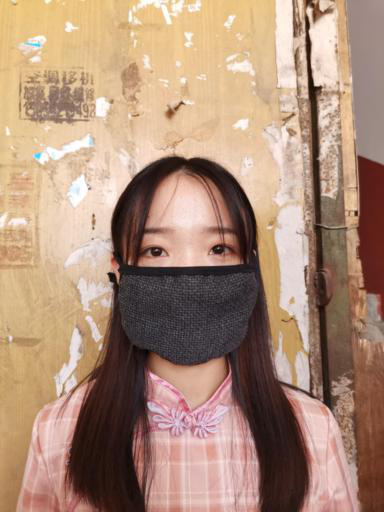

In [10]:
Image.open(os.path.join(image_paths[500], 'mask5.jpg'))

In [11]:
# 이미지 사이즈
example_image = Image.open(os.path.join(image_paths[500], 'mask5.jpg'))
np.array(example_image).shape

(512, 384, 3)

### 분석 대상이 되는 객체의 위치
- 곁눈질로 확인해보면, 거의 **정중앙**에 위치하고 잇는 것으로 나타난다. -> 어떻게 처리하는것이 좋을까? 
    1. object detection으로 얼굴만 추출하여 데이터를 정제한다. 
        - Detection에 대한 레이블이 없기 때문에 새로운 모델을 통해서는 해당 방법을 활용하지 못한다. (노가다? 가능? 응 안대~)
            - mask detection 으로 pretrained model 이 있을까? 
            - mask detection 기능을 제대로 잘 수행하는 pre-trained model이 있을까?
            - ??? 더 있나...?
    2. image segmentaion으로 마스크의 위치 정보를 파악한다. -> 레이블 데이터가 없어...  
    3. (Rough) 가장 보수적인 크기를 지정하여 제일 필요 없을것 같은 부분을 자른다. 
    4. (혹시 이런 방법은?)
- (그냥 내 생각) 얼굴만 자른다고 얼굴과 마스크의 위치만으로 충분한 정보가 될까?   
  배경은 필요가 없을수도 있지만, 상체의 shape은 어느정도 유지가 되어야하는것은 아닐까?
    
- TRY (Experiments) 성능테스트에 해볼만한것.
    1. 가운데 Crop
    2. 어깨 너비와 정수리 기준으로 Crop
    3. 
    


### RGB 채널별 통계 값
- 이거 머 말하는걸까...?

In [18]:
# 이미지 파일을 list에 저장
train_data_list = []
for i, who in enumerate(image_paths):
    images = [image for image in os.listdir(who) if image[0] != '.']
    for j, types in enumerate(sorted(images)) : 
        train_data_list.append((Image.open(os.path.join(who, types))))

In [19]:
train_data_list[:3]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512 at 0x7F4A166AA400>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512 at 0x7F4A166AAEB0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512 at 0x7F4A16704E80>]

In [20]:
image_mean = np.zeros_like(train_data_list[0])
for i in range(5):
    image_mean += np.array(train_data_list[i])
image_mean = image_mean/5
print(image_mean)

[[[42.2 39.  33.2]
  [42.2 39.  33.2]
  [42.2 39.  33.2]
  ...
  [47.6 45.  39.4]
  [46.4 43.8 38.2]
  [45.4 42.8 37.2]]

 [[42.2 39.  33.2]
  [42.2 39.  33.2]
  [42.2 39.  33.2]
  ...
  [47.6 45.  39.4]
  [46.4 43.8 38.2]
  [45.4 42.8 37.2]]

 [[42.2 39.  33.2]
  [42.2 39.  33.2]
  [42.2 39.  33.2]
  ...
  [47.2 44.6 39. ]
  [46.2 43.6 38. ]
  [45.2 42.6 37. ]]

 ...

 [[29.6 34.4  1.2]
  [27.6 32.6  0.2]
  [25.6 31.  50.4]
  ...
  [ 7.8  3.4 18.6]
  [ 9.   4.  19.4]
  [ 9.6  4.6 20. ]]

 [[25.4 30.4 48.8]
  [23.6 28.6 47.4]
  [21.4 27.  46.4]
  ...
  [ 5.4  1.  16.8]
  [ 6.   1.2 16.6]
  [ 6.6  1.8 17.2]]

 [[19.2 24.2 42.6]
  [18.2 23.8 42.4]
  [17.2 22.8 42.2]
  ...
  [ 2.  48.  13.4]
  [ 2.8 48.4 13.6]
  [ 2.8 48.4 13.6]]]


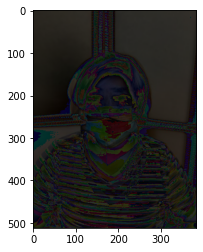

In [21]:
plt.imshow(np.int32(image_mean))

## target이 될 y에 대한 분석
### bining age => `age_range`

In [25]:
def get_age_range(age):
    if age < 30:
        return 0
    elif age < 60:
        return 1
    else :
        return 2

train_info['age_range'] = train_info['age'].apply(lambda x : get_age_range(x))

In [26]:
train_info.head()

id  gender   race  age                    path  age_range
0  000001  female  Asian   45  000001_female_Asian_45          1
1  000002  female  Asian   52  000002_female_Asian_52          1
2  000004    male  Asian   54    000004_male_Asian_54          1
3  000005  female  Asian   58  000005_female_Asian_58          1
4  000006  female  Asian   59  000006_female_Asian_59          1

### y값에 독립적 분포 확인

Label => y

In [30]:
train_info['pre_label'] = pd.Series(map(lambda x: 0 if x == 'male' else 1,train_info['gender'])) + train_info['age_range']
train_info.head()

id  gender   race  age                    path  age_range  pre_label
0  000001  female  Asian   45  000001_female_Asian_45          1          2
1  000002  female  Asian   52  000002_female_Asian_52          1          2
2  000004    male  Asian   54    000004_male_Asian_54          1          1
3  000005  female  Asian   58  000005_female_Asian_58          1          2
4  000006  female  Asian   59  000006_female_Asian_59          1          2

- 기본적으로  
    wear : incorrect : not wear = 6: 1: 1 구성을 유지하고 있다. 


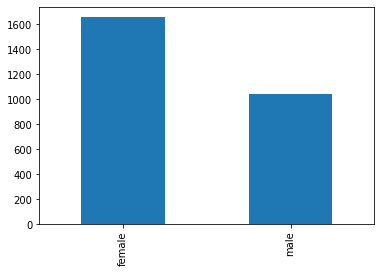

In [33]:
train_info['gender'].value_counts().plot(kind = 'bar')

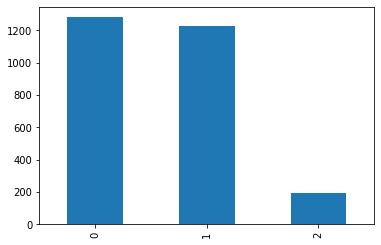

In [34]:
train_info['age_range'].value_counts().plot(kind = 'bar')

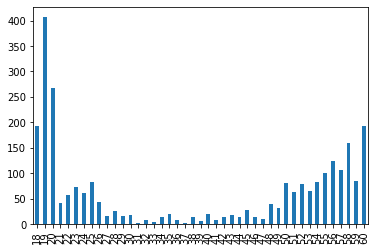

In [38]:
train_info['age'].value_counts().sort_index().plot(kind = 'bar')

In [39]:
train_info['age'].value_counts().sort_index()

18    192
19    407
20    267
21     41
22     58
23     72
24     62
25     82
26     44
27     15
28     25
29     16
30     17
31      3
32      7
33      5
34     13
35     19
36      8
37      3
38     14
39      6
40     20
41      7
42     13
43     18
44     13
45     27
46     14
47     10
48     39
49     31
50     80
51     63
52     78
53     64
54     82
55    100
56    123
57    106
58    159
59     85
60    192
Name: age, dtype: int64

- 60세 이상은 60세 하나 범주밖에 없다. -> 어떻게 처리해야하나? 
- Test data에는 60세 이상이 더 많을까???

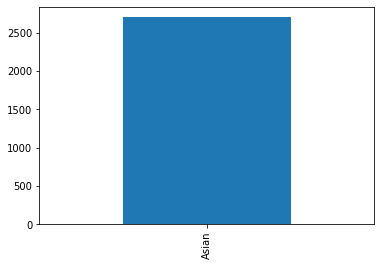

In [40]:
train_info['race'].value_counts().sort_index().plot(kind = 'bar')

- asian 밖에없다.